In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras import layers

Lectura de datos

In [2]:
# Cargar el archivo Excel
ruta_archivo = "02.Generación Pearson CT-NET.xlsx"

# Cargar los datos asegurando que 'Fecha' se interprete como índice y fecha
datos = pd.read_excel(ruta_archivo)

# Mostrar las primeras filas para verificar
datos.head()

,Fecha,Generación,Índice UV,Temperatura,Humedad Relativa
0,2022-09-01 00:00:00,0.0,0.0,19,77
1,2022-09-01 01:00:00,0.0,0.0,19,82
2,2022-09-01 02:00:00,0.0,0.0,18,85
3,2022-09-01 03:00:00,0.0,0.0,18,87
4,2022-09-01 04:00:00,0.0,0.0,18,88


In [3]:
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
datos_2 = datos.copy()
datos_2["Generacion_prev_hour"] = datos_2["Generación"].shift(1)
datos_dropna = datos_2.dropna(how="any", axis= 0)

In [5]:
datos_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18289 entries, 1 to 18289
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Fecha                 18289 non-null  datetime64[ns]
 1   Generación            18289 non-null  float64       
 2   Índice UV             18289 non-null  float64       
 3   Temperatura           18289 non-null  int64         
 4   Humedad Relativa      18289 non-null  int64         
 5   Generacion_prev_hour  18289 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 1000.2 KB


In [6]:
datos_sinfecha = datos_dropna.drop(["Fecha"], axis=1)

In [7]:
datos_sinfecha.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18289 entries, 1 to 18289
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Generación            18289 non-null  float64
 1   Índice UV             18289 non-null  float64
 2   Temperatura           18289 non-null  int64  
 3   Humedad Relativa      18289 non-null  int64  
 4   Generacion_prev_hour  18289 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 857.3 KB


In [8]:
datos_sinfecha.describe().T

,count,mean,std,min,25%,50%,75%,max
Generación,18289.0,9392.983969,11398.764291,0.0,0.0,533.0,21830.0,30000.0
Índice UV,18289.0,1.976613,3.181352,0.0,0.0,0.0,3.0,14.0
Temperatura,18289.0,19.456723,6.636719,0.0,15.0,19.0,24.0,39.0
Humedad Relativa,18289.0,58.878233,26.112575,3.0,37.0,62.0,83.0,100.0
Generacion_prev_hour,18289.0,9392.983969,11398.764291,0.0,0.0,533.0,21830.0,30000.0


In [9]:
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
X = datos_sinfecha.drop('Generación', axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X = X_scaled_df.copy()
y = datos_sinfecha['Generación']

In [11]:
#Porcentaje de entrenamiento
porcentaje = 0.5

#Horizonte de predicción
horizon = 1

#División de datos
lentrain100 = int(len(y) * porcentaje)
lentrain100

9144

In [12]:
#Dividimos 80/20
X_train, X_test = X.iloc[:lentrain100, :], X.iloc[lentrain100:, :]
y_train, y_test = y.iloc[:lentrain100], y.iloc[lentrain100:]

In [13]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (9144, 4)
X_test: (9145, 4)
y_train: (9144,)
y_test: (9145,)


In [14]:
def transform_data(data_to_transform):
    scaler = MinMaxScaler()
    scaler = scaler.fit(data_to_transform)
    trans_data = scaler.transform(data_to_transform)
    return trans_data

In [15]:
def to_supervised(X, y, n_input):
    X_supervised, y_supervised = [], []
    
    for i in range(len(X) - n_input):
        # Extraemos una ventana de `n_input` pasos como entrada
        X_supervised.append(X.iloc[i:i + n_input, :].values)  
        # Predicción: solo 1 paso adelante
        y_supervised.append(y.iloc[i + n_input])  

    return np.array(X_supervised), np.array(y_supervised)

In [16]:
def split_dataset(data):
    train = np.array(np.split(data, len(data)/12))
    return train

In [17]:
# Definir ventana de entrada (ejemplo: 12 horas de datos pasados)
n_input = 1  

# Convertir `X_train` y `X_test` a formato supervisado
X_train_supervised, y_train_supervised = to_supervised(X_train, y_train, n_input)
X_test_supervised, y_test_supervised = to_supervised(X_test, y_test, n_input)

# Verificar las dimensiones finales
print("X_train_supervised:", X_train_supervised.shape)  # (samples, 12, features)
print("y_train_supervised:", y_train_supervised.shape)  # (samples,)
print("X_test_supervised:", X_test_supervised.shape)
print("y_test_supervised:", y_test_supervised.shape)

X_train_supervised: (9143, 1, 4)
y_train_supervised: (9143,)
X_test_supervised: (9144, 1, 4)
y_test_supervised: (9144,)


In [18]:
print('shape of Training_input:', X_train.shape)
print('shape of Training_output:', y_train.shape)

shape of Training_input: (9144, 4)
shape of Training_output: (9144,)


In [19]:
# Training Parameters
MAX_EPOCHS = 200

In [20]:
def compile_and_fit(model, xtrain=X_train_supervised, ytrain=y_train_supervised):
    model.compile(loss=[tf.keras.losses.MeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(xtrain, ytrain, epochs=MAX_EPOCHS,
                        batch_size=512, validation_split=0.3, verbose=1)
    return history

In [21]:
def Loss(train_loss, valid_loss):
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.rcParams["figure.figsize"] = (15, 3)
    plt.ylabel('Pérdida')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento Pérdida', 'Validación Pérdida'], loc='upper left')
    plt.show()

In [22]:
def errors(Train_RMSE, Valid_RMSE, train_MAPE, Valid_MAPE):
    plt.plot(Train_RMSE)
    plt.plot(Valid_RMSE)
    plt.plot(train_MAPE)
    plt.plot(Valid_MAPE)
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento RMSE', 'Validación RMSE', 'Entrenamiento MAPE', 'Validación MAPE'], loc='upper left')
    plt.rcParams["figure.figsize"] = (15, 3)
    plt.show()

In [23]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization()(inputs)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", padding="same")(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation="relu", padding="same")(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    res = x + inputs
    norm_x = layers.LayerNormalization()(res)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(norm_x, norm_x)
    res = x + inputs
    norm_x = layers.LayerNormalization()(res)
    return norm_x

In [24]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):
        enc_out = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(enc_out, enc_out)
    res = x + enc_out
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = layers.Dense(832, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)
    
    return tf.keras.Model(inputs, outputs)

In [25]:
input_shape = (1, 4)
CTNET = build_model(input_shape, head_size=4, num_heads=3, ff_dim=32, num_transformer_blocks=3, mlp_units=[256], mlp_dropout=0.3, dropout=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 4)      │          8 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1, 32)     │        160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1, 128)    │      8,320 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1, 4)      │        516 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1, 4)      │          0 │ conv1d_8[0][0],   │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 4)      │          8 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 4)      │        232 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 1, 4)      │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 4)      │          8 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 4)      │        232 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 1, 4)      │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 4)      │          8 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 832)       │      1,664 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    106,624 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 126,101 (492.58 KB)

 Trainable params: 126,101 (492.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


c:\Users\Claudia\anaconda3\envs\tesina_env\lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 3, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - loss: 189210832.0000 - mean_absolute_error: 8285.8623 - mean_absolute_percentage_error: 3053328.2500 - root_mean_squared_error: 13753.5654 - val_loss: 297510208.0000 - val_mean_absolute_error: 11790.2227 - val_mean_absolute_percentage_error: 13121479.0000 - val_root_mean_squared_error: 17248.4844
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 192639792.0000 - mean_absolute_error: 8399.1816 - mean_absolute_percentage_error: 18929240.0000 - root_mean_squared_error: 13879.1357 - val_loss: 297509152.0000 - val_mean_absolute_error: 11790.2158 - val_mean_absolute_percentage_error: 31622348.0000 - val_root_mean_squared_error: 17248.4531
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 190004272.0000 - mean_absolute_error: 8296.6006 - mean_absolute_percentage_error: 41233824.0000 - root_mean_squared_error: 13783.8535 - val_loss: 297507776.0000 - val_mean_absolute_error: 11790.2090 - val_mean_absolute_percentage_error: 57050472

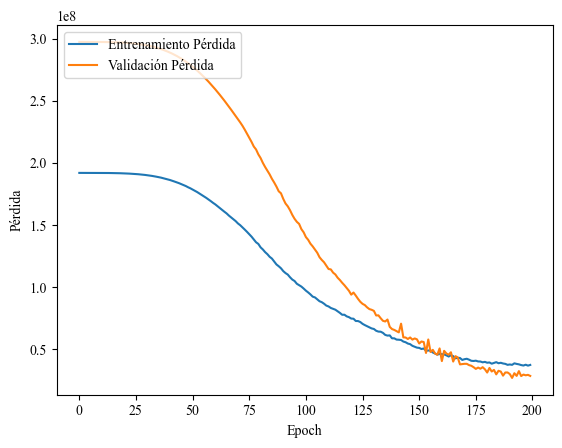

In [26]:
CTNET.summary()
history = compile_and_fit(CTNET)
Loss(history.history['loss'], history.history['val_loss'])
#Loss(history.history['loss'], history.history['val_loss'])

CTNET.save('out/CTNET.h5')

In [27]:
#Evaluar en cada segmento de 1 día dentro del 20% de los datos
num_pruebas = len(X_test)
num_pruebas

9145

In [28]:
horizon = 1

In [29]:
# Inicializar listas para métricas
resultados = pd.DataFrame(columns=['Hora', 'Real', 'Predicho'])
#Ciclo diario de predicción
for i in range(num_pruebas):
    inicio = i * horizon
    fin = inicio + horizon

    X_test_seg = X_test.iloc[inicio:fin, :]
    y_test_seg = y_test.iloc[inicio:fin]

    if len(X_test_seg) < horizon:
        break

    # 🔹 Añadir dimensión extra para que tenga la forma esperada
    X_test_seg_reshaped = np.expand_dims(X_test_seg, axis=1)  # (samples, 1, features)

    y_pred = CTNET.predict(X_test_seg_reshaped)
    y_pred = np.clip(y_pred, 0, 30000)  # 🔹 Limitamos entre 0 y 30,000

    df_temp = pd.DataFrame({
        'Hora': X_test_seg.index,
        'Real': y_test_seg,
        'Predicho': y_pred.flatten()
    })

    resultados = pd.concat([resultados, df_temp], ignore_index=True)

c:\Users\Claudia\anaconda3\envs\tesina_env\lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 3, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\Claudia\AppData\Local\Temp\ipykernel_18244\2944266597.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, df_temp], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1

In [30]:
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from sklearn.metrics import r2_score as r2_score

In [31]:
print(f"MAE: {mean_absolute_error(resultados['Real'], resultados['Predicho']):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(resultados['Real'], resultados['Predicho'])):.4f}")
print(f"R²: {r2_score(resultados['Real'], resultados['Predicho']):.4f}")

MAE: 4014.8201
RMSE: 6019.9320
R²: 0.7094


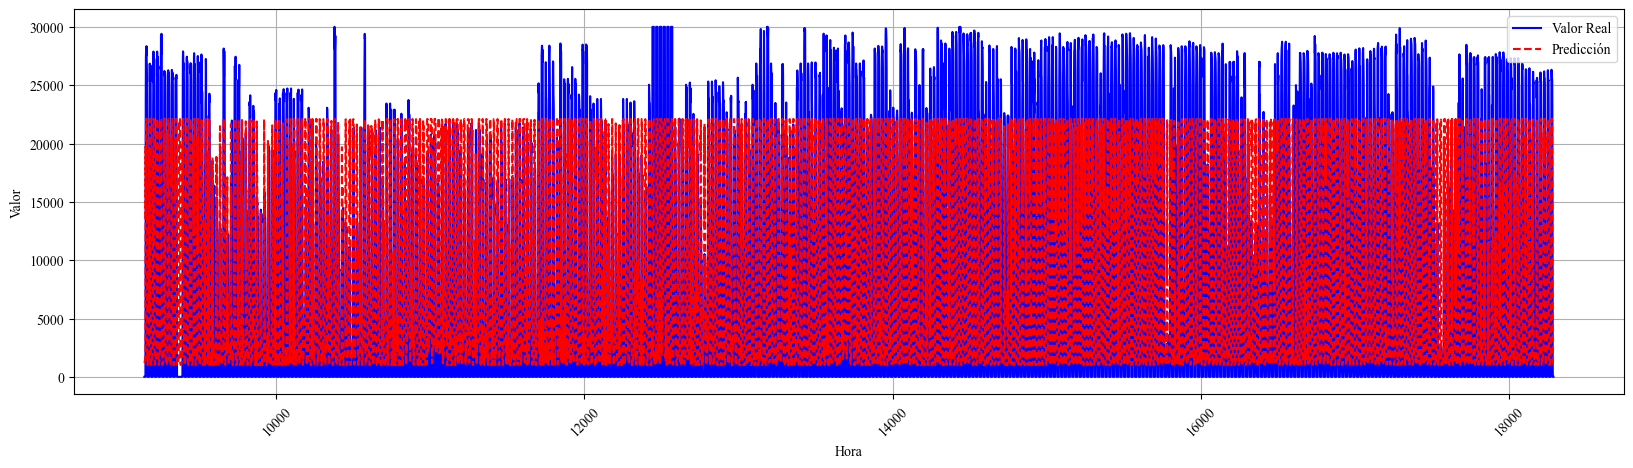

In [32]:
plt.figure(figsize=(20, 5))
plt.plot(resultados['Hora'], resultados['Real'], label='Valor Real', color='blue')
plt.plot(resultados['Hora'], resultados['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

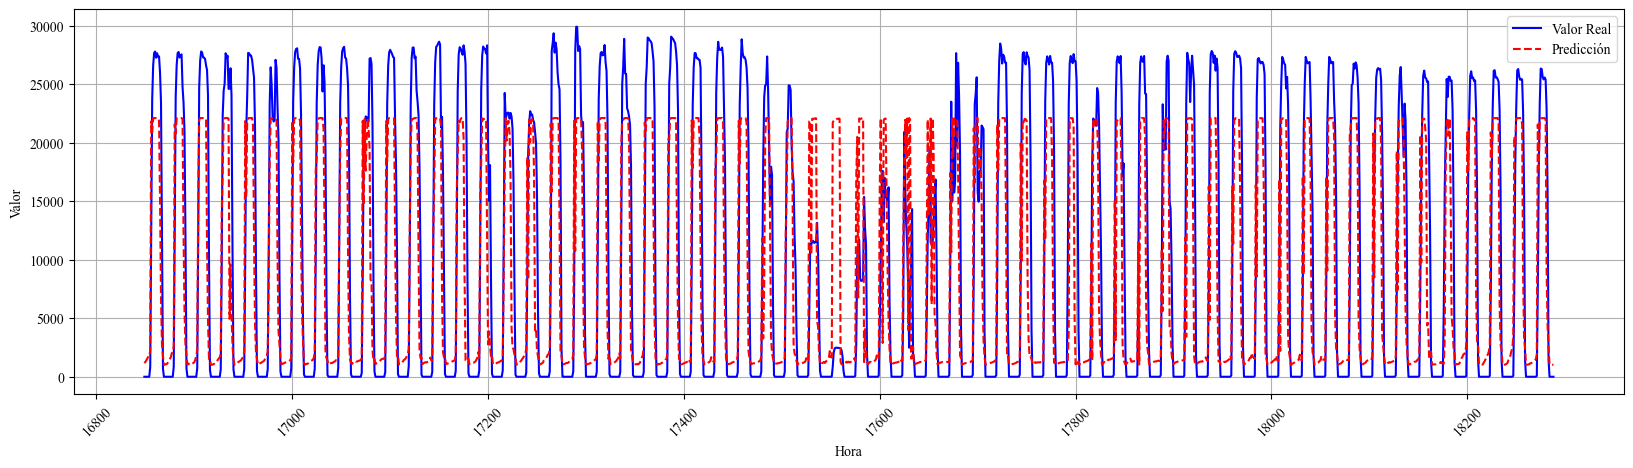

In [33]:
resultados_filtro = resultados.iloc[-(24*60):,:]
plt.figure(figsize=(20, 5))
plt.plot(resultados_filtro['Hora'], resultados_filtro['Real'], label='Valor Real', color='blue')
plt.plot(resultados_filtro['Hora'], resultados_filtro['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

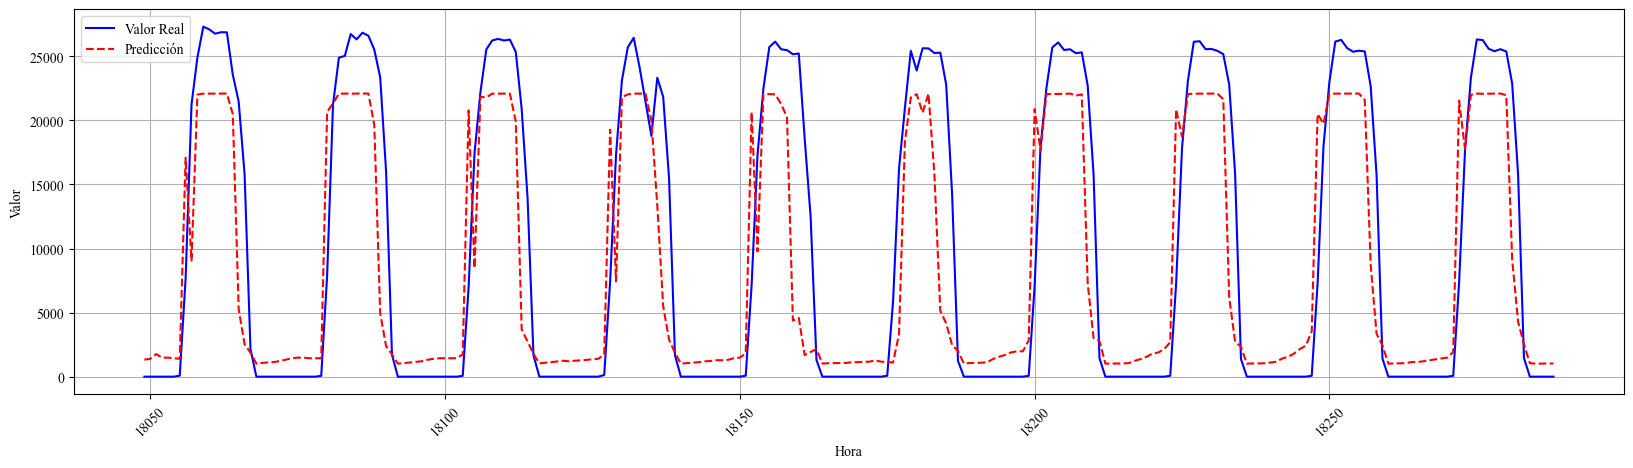

In [34]:
resultados_filtro = resultados.iloc[-(24*10):,:]
plt.figure(figsize=(20, 5))
plt.plot(resultados_filtro['Hora'], resultados_filtro['Real'], label='Valor Real', color='blue')
plt.plot(resultados_filtro['Hora'], resultados_filtro['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()